# Install Packages

In [1]:
# pip install -e ./lib/quantum_electron-main/quantum_electron-main/

In [2]:
# pip install -e ./lib/zeroheliumkit_0.5.0_win

# Imports

In [3]:
import os
import sys
import yaml
import numpy as np
import matplotlib.pyplot as plt

from zeroheliumkit import Structure, Rectangle, GeomCollection
from zeroheliumkit.src.importing import Reader_GDS,Reader_DXF,Reader_Pickle
from zeroheliumkit.fem import *
from zeroheliumkit.src.settings import  *

%matplotlib inline
%config InlineBackend.figure_format='retina'

plot_config = {'wafer':BLACK,'bottom':YELLOW2,'top':(BLUE,0.6)}

# Device Importing

reduced_twiddleSense.gds // Layers in cell 'TOP': {28, 22}


<Axes: >

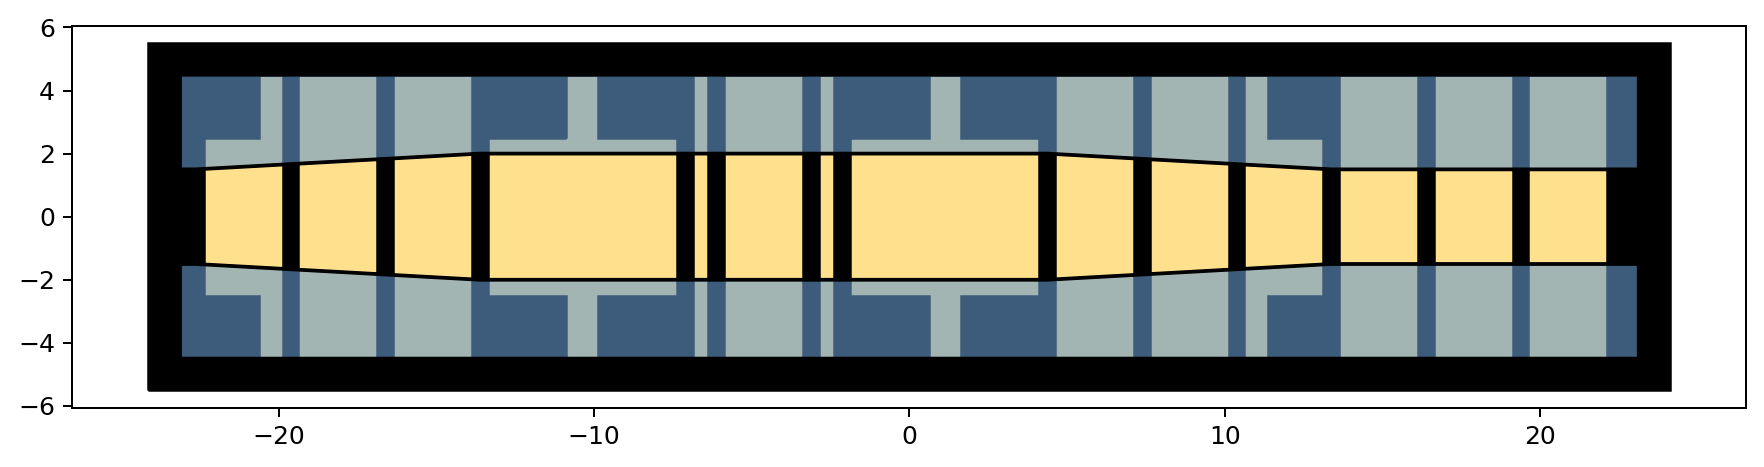

In [4]:
# Read File
file = Reader_GDS('reduced_twiddleSense.gds')
file.import2zhk("TOP")
device = GeomCollection(file.geometries)

#Add a "wafer" Layer
device.add_layer('wafer', Rectangle(46.25+2,9+2,(0,0)))

# Rename Layers
# device.rename_layer('L0','extra')
device.rename_layer('L22','bottom')
device.rename_layer('L28','top')
device.layers

#Show Device
device.quickplot(plot_config)

# Viewing Electrodes

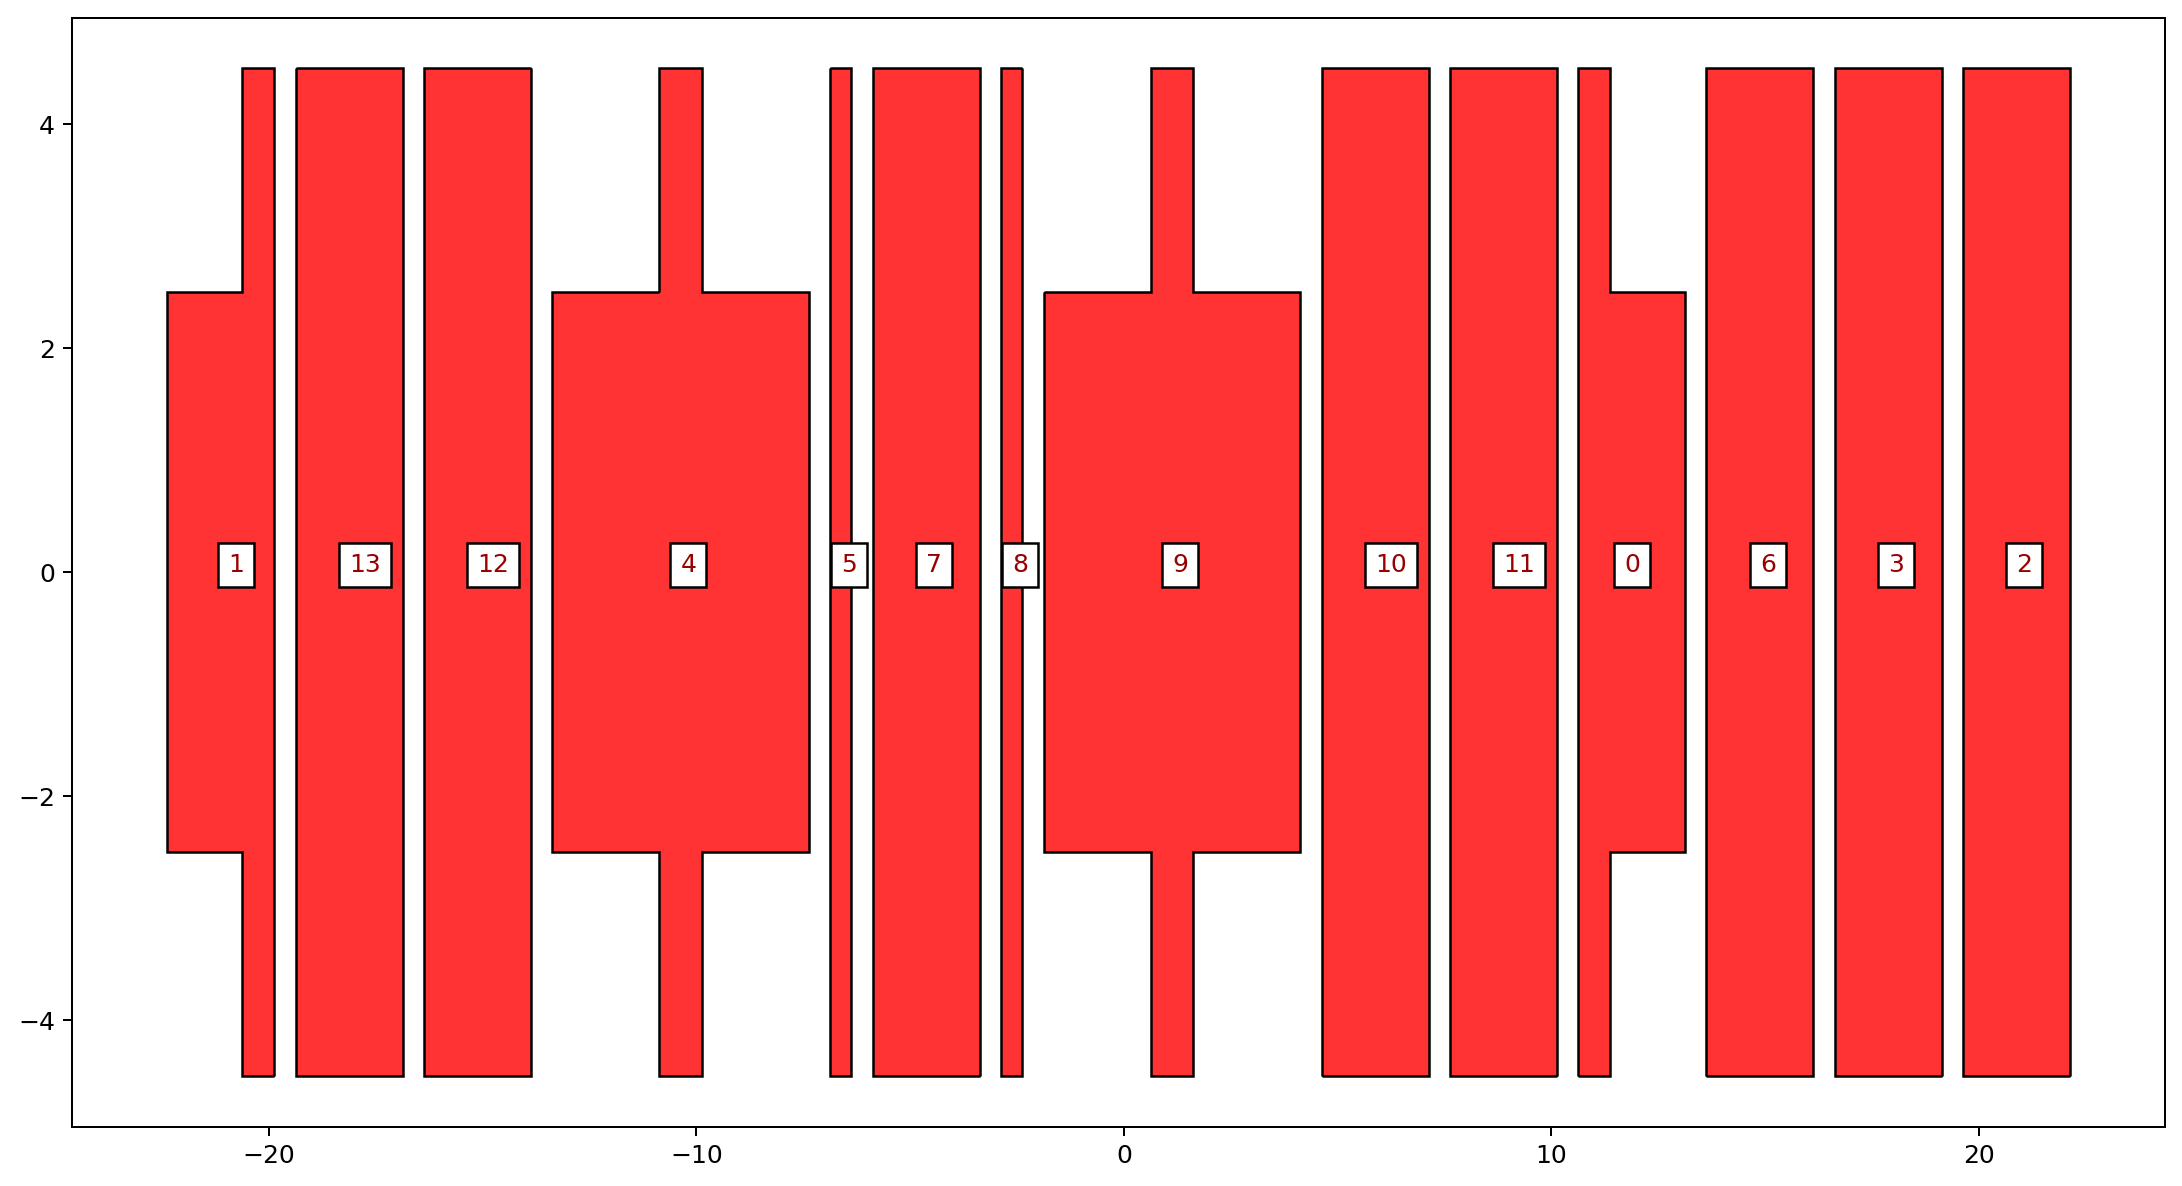

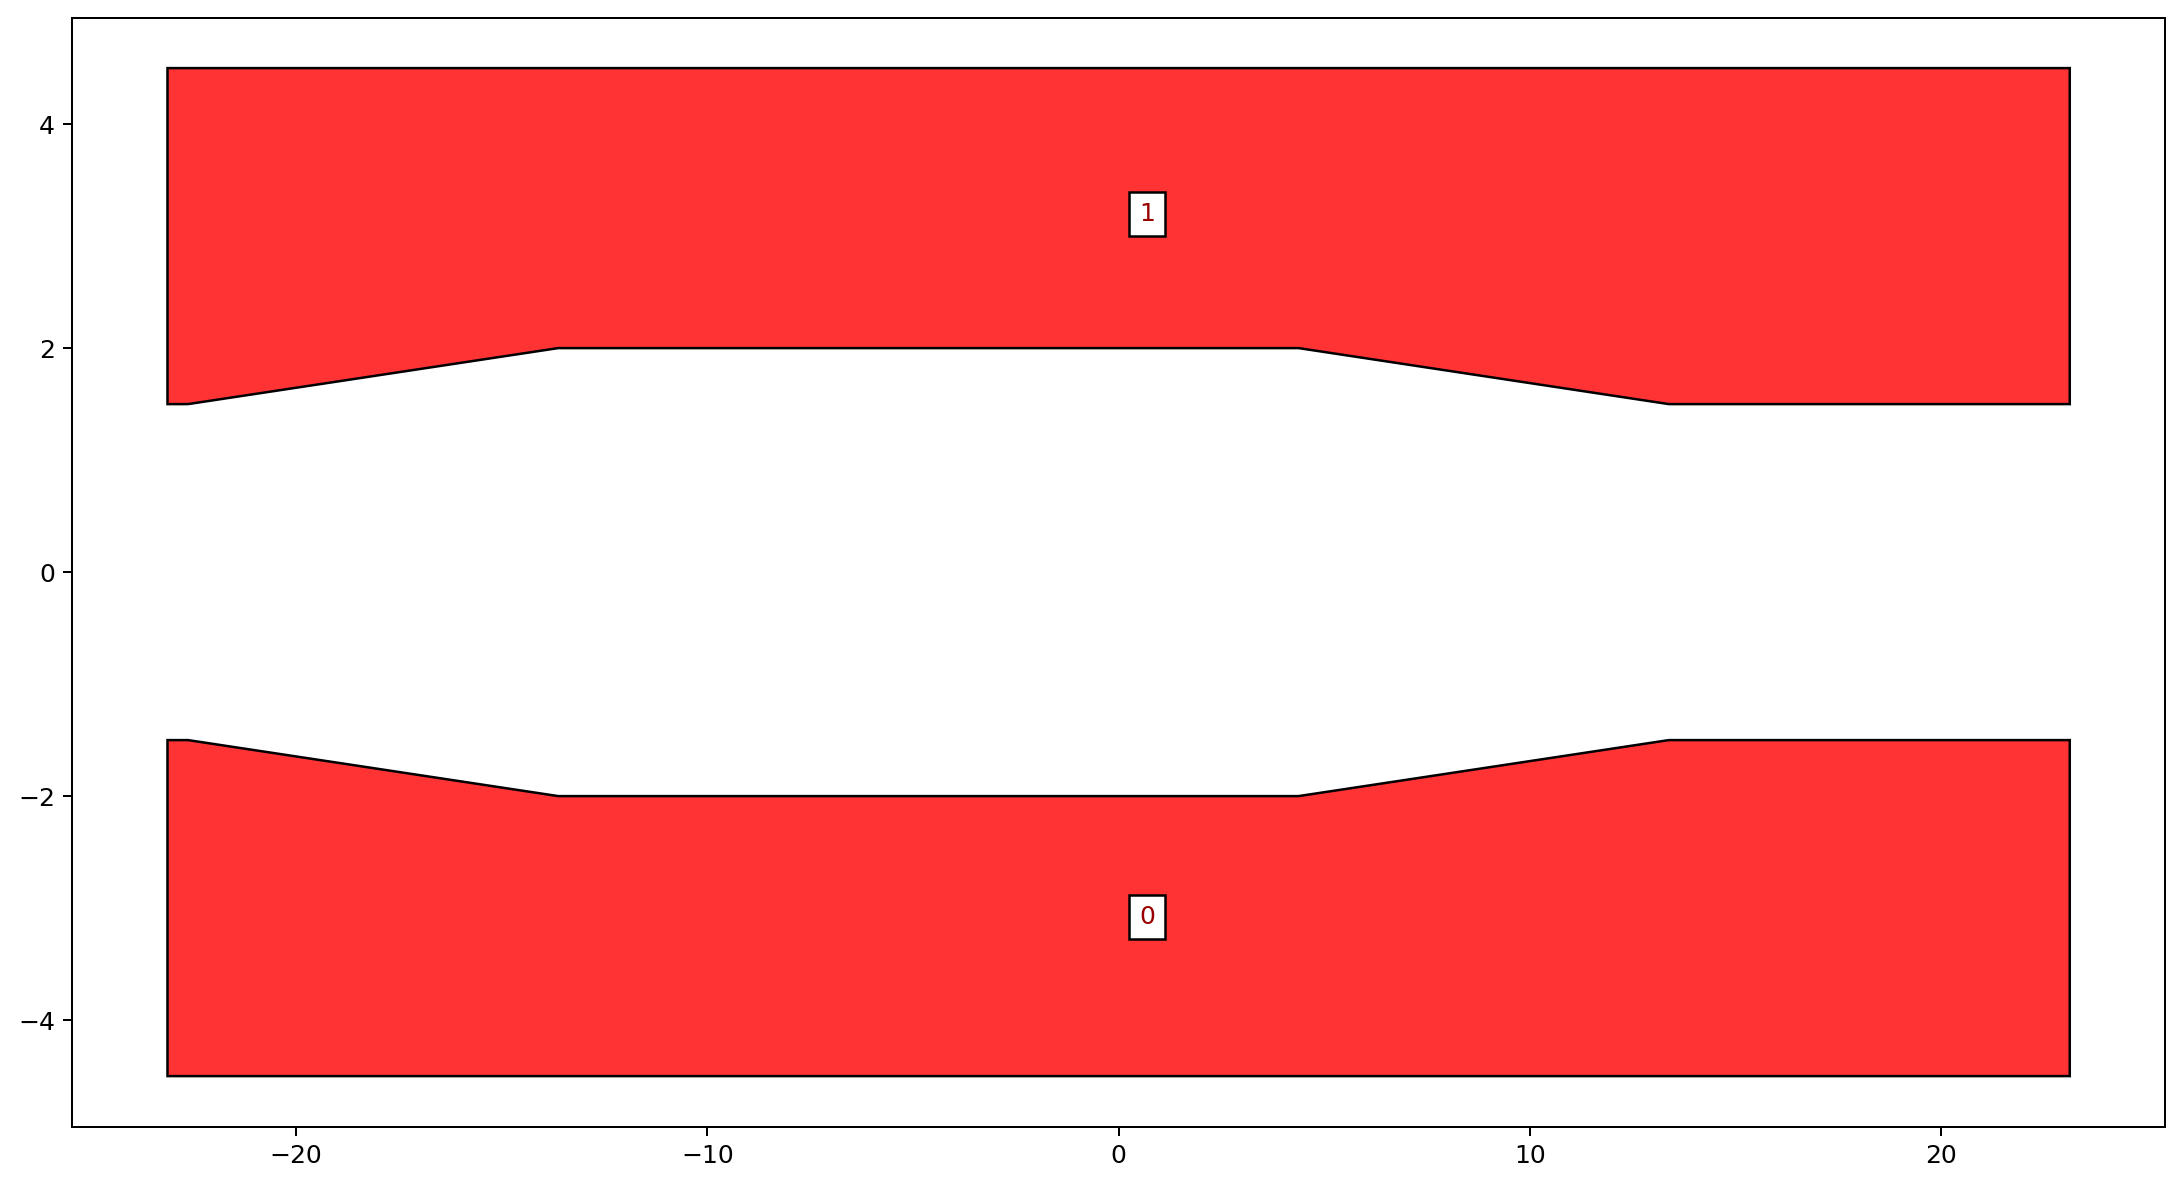

In [5]:
for layer in ["bottom","top"]:
    fig = plt.figure(1, figsize=(15,8), dpi=90)
    ax = fig.add_subplot(111)
    device.plot(ax=ax, layer=[layer],color=[RED],show_idx=True)
    plt.show()

# Define 3D Geometry

In [25]:
d_metal4 = 0.870 # Al
d_metal5 = 0.250 + 0.020 # Nb + Al etch stop
d_diel  = 0.960 # SiO2
d_vac   = 25
d_He    = 1.12 # d_diel + d_metal5
d_total = d_metal4 + d_He

extrude_config = {
    'wafer' :       gmshLayer_info('wafer'    , -d_vac/2 , d_vac/2        , 'WAFERDIELECTRIC'),
    'bottom':       gmshLayer_info('bottom'   , 0 , d_metal4               , 'METAL'),
    'dielectric':   gmshLayer_info('top'      , d_metal4 , d_diel          , 'DIELECTRIC'),
    'top':          gmshLayer_info('top'      , d_metal4+d_diel, d_metal5  , 'METAL'),
    'filler':       gmshLayer_info('wafer'    , 0, d_metal4                , 'DIELECTRIC', ('bottom','dielectric')),
    'helium':       gmshLayer_info('wafer'    , d_metal4, d_He             , 'HELIUM', ('dielectric','top')),
    'vacuum':       gmshLayer_info('wafer'    , 0, d_vac       , 'VACUUM', ('wafer','bottom','dielectric','top','filler','helium'))
}

electrodes_config = {
    'Phi_h1_3':        physSurface_info('bottom',   [0,2], 'bottom'),
    'Phi_h1_1':        physSurface_info('bottom',   [1,6], 'bottom'),
    'D4':        physSurface_info('bottom',   [3,11,13], 'bottom'),
    'Sense1':      physSurface_info('bottom',   [4], 'bottom'),
    'Guard1':        physSurface_info('bottom',   [5], 'bottom'),
    'Twiddle':        physSurface_info('bottom',   [7], 'bottom'),
    'Guard2':        physSurface_info('bottom',   [8], 'bottom'),
    'Sense2':        physSurface_info('bottom',   [9], 'bottom'),
    'D6':        physSurface_info('bottom',   [10], 'bottom'),
    'D5':        physSurface_info('bottom',   [12], 'bottom'),
    'Top':          physSurface_info('top',    [0,1], 'top'),
}

mediumregion_box = [-18, 0, -4.5, 4.5, -0.7, 6] # x1, x2, y1, y2, z1, z2
fineregion_box = [-15, -2.5, 0, 2.5, -0.1, 4.5]
scale = 4
mesh_params = [{"Thickness": 4, "VIn": scale * 0.1, "VOut": .5*scale, "box": mediumregion_box},
               {"Thickness": 2, "VIn": scale * 0.05, "VOut": .5*scale, "box": fineregion_box}
              ]

# Generate Mesh

In [26]:
save_dir = 'dump/'
mshID = 'GordianSensor_20251121'
meshMKR =  GMSHmaker(layout=device, 
                     extrude_config=extrude_config, 
                     electrodes_config=electrodes_config, 
                     mesh_params=mesh_params)
meshMKR.create_geo(save_dir+mshID )
meshMKR.create_mesh(save_dir+mshID, dim=3)
meshMKR.open_gmsh()
meshMKR.finalize()

on 0: mesh is constructed                                                       
on 0: mesh saved                                                                
Gmsh generation  |███| 1/1 [100%] in 4.1s (0.25/s)                              


# Create edp file

In [36]:
He_level = round(d_total,3)

var_eps = {
        'WAFERDIELECTRIC': 11,
        'DIELECTRIC': 3.9, #11.0,
        'METAL': 1.0,
        'HELIUM': 1.057,
        'VACUUM': 1.0,
}

ff_config ={
    'meshfile': save_dir+mshID,
    'dielectric_constants': var_eps,
    'ff_polynomial': 2,
    'extract_opt': [extract_results('phi', 'xy', (-16.875, -1.875,1001), (-2.5, 2.5,201), He_level,'twiddleSense_20251121'),
                    ],
    'physicalSurfaces': {k: v.get('group_id') for (k, v) in meshMKR.physicalSurfaces.items()},
    'physicalVolumes': {k: v.get('group_id') for (k, v) in meshMKR.physicalVolumes.items()}
}

with open(save_dir+r'config.yaml', 'w') as file:
    documents = yaml.safe_dump(ff_config, file)

In [ ]:
with open(save_dir+r'config.yaml', 'r') as file:
    config = yaml.safe_load(file)

yff = FreeFEM(config=config,
               dirname='./',
               run_from_notebook=False)

: 

In [ ]:
!cd C:\Users\Lyon Lab Simulation\Documents\GitHub\LyonLabCodebase\zeroHeliumKitSims\Gordian
!freefem++ ./dump/GordianSensor.edp

Then in a terminal, cd to this folder and run: "freefem++ ./dump/GordianSensor.edp"